In [ ]:
!pip install scikit-surprise

In [ ]:
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances

import re
from scipy.sparse import csr_matrix
import scipy as sp


# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
import heapq

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

## Loading Datasets

In [316]:
# Load the necessary datasets
movies_df = pd.read_csv('movies.csv')
imdb_df = pd.read_csv('imdb_data.csv')
links_df = pd.read_csv('links.csv')
tags = pd.read_csv('tags.csv')
genome_scores = pd.read_csv('genome_scores.csv')
genome_tags = pd.read_csv('genome_tags.csv')
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [317]:
# Preview datasets
print('The Shape of the movies data is: ', movies_df.shape)
print(movies_df.head(3))

print("********************************************************")
print('The Shape of the  Train data is: ', imdb_df.shape)
print(train_df.head(3))


The Shape of the movies data is:  (62423, 3)
   movieId                    title  \
0        1         Toy Story (1995)   
1        2           Jumanji (1995)   
2        3  Grumpier Old Men (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
********************************************************
The Shape of the  Train data is:  (27278, 6)
   userId  movieId  rating   timestamp
0    5163    57669     4.0  1518349992
1  106343        5     4.5  1206238739
2  146790     5459     5.0  1076215539


In [318]:
print(movies_df.info())
print('------------------------')
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB
None
------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB
None


In [319]:
train_df.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [320]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [321]:
# group by ratings for visualization
ratings_df = train_df.groupby(['rating']).count()

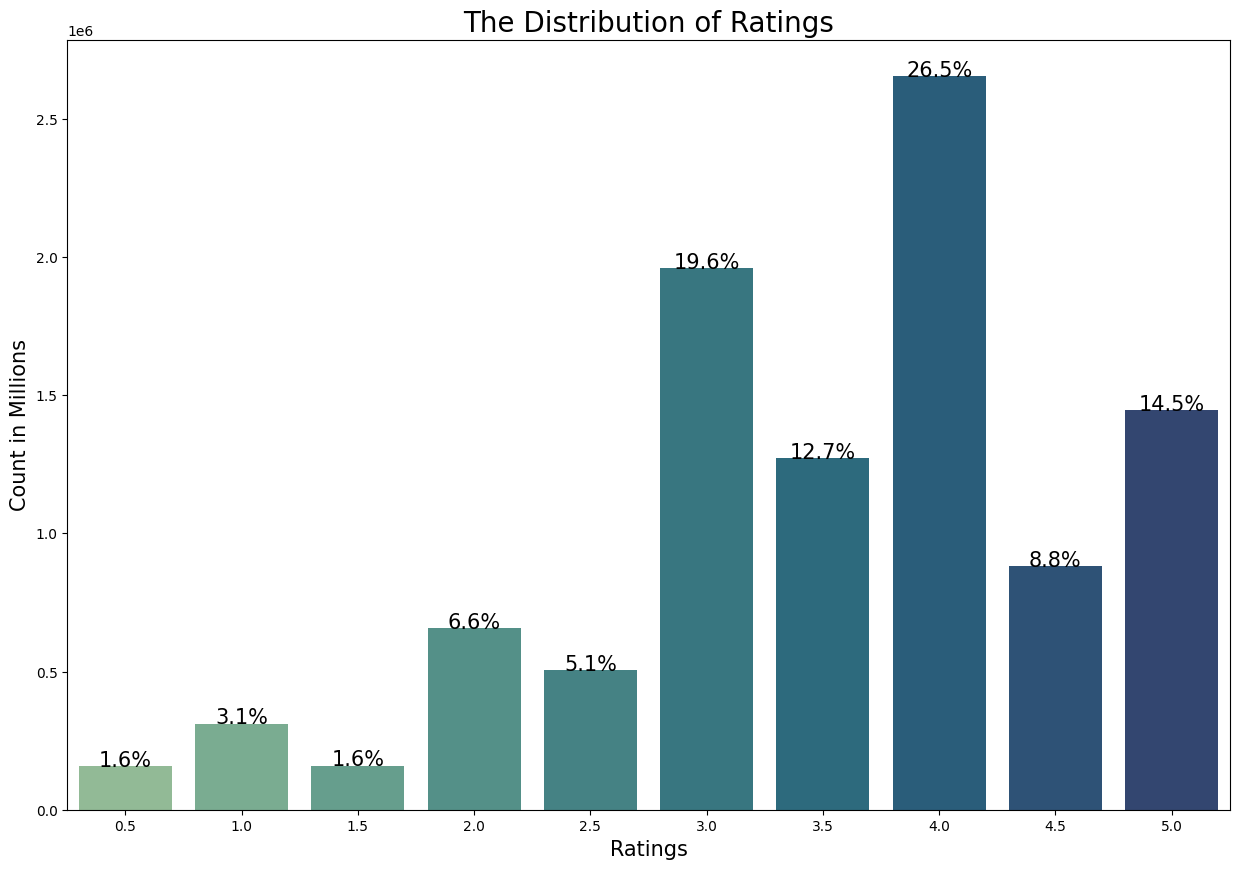

In [322]:
#Plot showing the distribution of counts
plot = plt.figure(figsize=(15, 10))
a = sns.barplot(x=ratings_df.index,y='userId',data=ratings_df,palette='crest')
a.set_title('The Distribution of Ratings',fontsize=20)
a.set_ylabel('Count in Millions',fontsize=15)
a.set_xlabel('Ratings',fontsize=15)

#Obtaining percentages on top of bars
n_obs = [i.get_height() for i in a.patches]
total = sum(n_obs)

for i in a.patches:
    # get_x pulls left or right; get_height pushes up or down
    a.text(i.get_x()+i.get_width() / 2, i.get_height()+0.5, \
            str(round((i.get_height()/total)*100, 1))+'%', fontsize=15,
                color='black',ha='center')

plt.show()


In [323]:
movies_df['movieId'].nunique()

62423

In [324]:
train_df['movieId'].nunique()

48213

In [325]:
#movie_case = movies_df['movieId'].unique()
#train_case = train_df['movieId'].unique()
#print([id for id in movie_case if id in train_case])

In [326]:
# Sort train dataset by movieId
train_df.sort_values(by=['movieId'], inplace= True)
train_df.head()

,userId,movieId,rating,timestamp
5318360,30656,1,4.0,938508612
1138504,104139,1,5.0,1241744540
6951432,52794,1,2.5,1136086452
6334589,6586,1,4.0,1043530748
9745606,83665,1,5.0,1494516956


In [327]:
# Sort movies dataset by movieId
movies_df.sort_values(by=['movieId'], inplace= True)
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [328]:
# Merge based on the columns movieId, and movieId
merged_df = pd.merge(train_df, movies_df, left_on=['movieId', 'movieId'], right_on=['movieId', 'movieId'], how='inner')
merged_df.head()

,userId,movieId,rating,timestamp,title,genres
0,30656,1,4.0,938508612,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,104139,1,5.0,1241744540,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,52794,1,2.5,1136086452,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,6586,1,4.0,1043530748,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,83665,1,5.0,1494516956,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [329]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
 4   title      object 
 5   genres     object 
dtypes: float64(1), int64(3), object(2)
memory usage: 457.8+ MB


In [330]:
# drop unwanted columns in modelling and producing recommendations
merged_df.drop(columns=['timestamp', 'genres'], axis=1, inplace=True)
merged_df.head()

,userId,movieId,rating,title
0,30656,1,4.0,Toy Story (1995)
1,104139,1,5.0,Toy Story (1995)
2,52794,1,2.5,Toy Story (1995)
3,6586,1,4.0,Toy Story (1995)
4,83665,1,5.0,Toy Story (1995)


In [257]:
# Sample the data if the full dataset is too large to handle
sampled_df = merged_df.sample(n=10000, random_state=42)

# Sort the sampled DataFrame on the userId column
sampled_df.sort_values(by='userId', inplace=True)

In [259]:
sampled_df.reset_index(drop=True, inplace=True)

In [346]:
sampled_df.isnull().sum()

userId     0
movieId    0
rating     0
title      0
dtype: int64

In a similar process to content filtering, where we first had to gather item features before we could compute their similarity, within collaborative filtering, we initially needed to gather all user ratings together by forming a utility matrix.

In [350]:
#construct our utility matrix easily by using the pivot_table function
util_matrix = sampled_df.pivot_table(index=['userId'],
                                     columns=['title'],
                                     values='rating')
util_matrix.shape

(9011, 3693)

In [352]:
# Create a neat version of the utility matrix to assist with plotting movie titles
#sampled_df['neat_title'] = sampled_df['title'].apply(lambda x: x[:20])
#util_matrix_neat = sampled_df.pivot_table(index=['userId'],
 #                                        columns=['neat_title'],
  #                                       values='rating')
#
#fig, ax = plt.subplots(figsize=(15,5))
#_ = sns.heatmap(util_matrix_neat[:100], annot=False, ax=ax).set_title('Movies Utility Matrix')


In [355]:
#sampled_df.drop(columns='neat_title', inplace=True)

In [357]:
# Normalize each row (a given user's ratings) of the utility matrix
util_matrix_norm = util_matrix.apply(lambda x: (x-np.mean(x)) / (np.max(x)-np.min(x)), axis=1)

# Fill NaN values with 0's, transpose matrix, and drop users with no ratings
util_matrix_norm.fillna(0, inplace=True)
util_matrix_norm = util_matrix_norm.T
util_matrix_norm = util_matrix_norm.loc[:, (util_matrix_norm != 0).any(axis=0)]

# Save the utility matrix in scipy's sparse matrix format
util_matrix_sparse = sp.sparse.csr_matrix(util_matrix_norm.values)

In [358]:
util_matrix_norm

userId,626,847,997,1748,1920,1924,2012,2269,2271,2403,...,160730,160747,160805,161046,161184,161220,161342,161586,161928,162271
title,,,,,,,,,,,,,,,,,,,,,
'night Mother (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(500) Days of Summer (2009),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Cloverfield Lane (2016),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Things I Hate About You (1999),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"10,000 BC (2008)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
[REC] (2007),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
[REC] 4: Apocalypse (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
xXx (2002),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can now compute the similarity between users based on the ratings they have given various movies

In [570]:
# Compute  the similarity matrix using the cosine similarity metric
cosine_similarity_matrix = cosine_similarity(util_matrix_sparse, util_matrix_sparse)

# Save the matrix as a dataframe to allow for easier indexing
#sim_df = pd.DataFrame(cosine_similarity_matrix,
                     #index=util_matrix_norm.columns,
                     #columns=util_matrix_norm.columns)

#sim_df[:5]

## Top-N Recommendations

In [572]:
def collab_generate_top_N_recommendations(movie_title, N=9):

    # Compute the pairwise distances using cosine between the movies
    #cosine_similarity_matrix = cosine_similarity(util_matrix_norm, util_matrix_norm)

    # Find the index for the movie title
    if movie_title not in util_matrix_norm.index:
        raise ValueError(f"Movie title '{movie_title}' not found in the dataset.")

    movie_index = util_matrix_norm.index.get_loc(movie_title)

    # Find the top similar movies
    similar_indices = cosine_similarity_matrix[movie_index].argsort()[1:N+1]

    # Retrieve the movie titles for the similar indices
    similar_movies = util_matrix_norm.index[similar_indices].tolist()

    recommendations = '\n'.join(similar_movies)

    return recommendations

In [582]:
recommended_movies = collab_generate_top_N_recommendations('Young Einstein (1988)')
print(recommended_movies)

Youth in Revolt (2009)
Your Name. (2016)
Young Sherlock Holmes (1985)
Young People Fucking (a.k.a. YPF) (2007)
Young Guns II (1990)
Young Guns (1988)
Young Frankenstein (1974)
Young Einstein (1988)
Young Doctors in Love (1982)


In [189]:
#util_matrix_norm[util_matrix_norm.index.str.contains('Zootopia')]

In [190]:
#indices = list(util_matrix_norm.index)
#indices.index('¡Three Amigos! (1986)')

In [191]:
#similar_indices = (distance_matrix[3650].argsort()[1:6])
#for i in similar_indices:
  #print(indices[i])

In [78]:
import pickle

In [457]:
pickle.dump(sampled_df, open('movies_list.pkl', 'wb'))
pickle.dump(cosine_similarity_matrix, open('similarity.pkl', 'wb'))
pickle.dump(util_matrix_norm, open('util_matrix.pkl', 'wb'))

In [459]:
pickle.load(open('movies_list.pkl', 'rb'))

,userId,movieId,rating,title
0,3,103228,3.0,Pacific Rim (2013)
1,12,55052,4.0,Atonement (2007)
2,43,2949,3.5,Dr. No (1962)
3,49,367,3.0,"Mask, The (1994)"
4,58,376,3.0,"River Wild, The (1994)"
...,...,...,...,...
9995,162504,1371,4.0,Star Trek: The Motion Picture (1979)
9996,162510,3793,3.5,X-Men (2000)
9997,162516,1013,3.0,"Parent Trap, The (1961)"
9998,162516,48414,3.0,Open Season (2006)
